In [60]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.model_selection import train_test_split
from typing import Dict, List, Tuple, Union
import pandas as pd
from collections import Counter
import json

In [61]:
def find_best_split(
    feature_vector: np.ndarray,
    target_vector: np.ndarray,
    task: str = "classification"
    ) -> Tuple[np.ndarray, np.ndarray, float, float]:
    def dispersion(y):
        return np.sum((y - np.mean(y)) ** 2)

    def gini(y):
        p1 = np.sum(y)
        p0 = 1. - p1 / y.shape[0]
        p1 /= y.shape[0]
        return 1 - p0**2 - p1**2

    def impurity(task, X, y, threshold):
        split = np.array(X <= threshold)
        l = y[split]
        r = y[~split]
        if task == "regression":
            l_criteria = dispersion(l)
            r_criteria = dispersion(r)
        else:
            l_criteria = gini(l)
            r_criteria = gini(r)
        return - l.shape[0] / y.shape[0] * l_criteria - r.shape[0] / y.shape[0] * r_criteria

    index = np.argsort(feature_vector)
    feature_vector = feature_vector[index]
    target_vector = target_vector[index]
    thresholds, impurities, threshold_best, impurity_best = [], [], -1, -np.inf
    for i in range(feature_vector.shape[0] - 1):
        cur_threshold = (feature_vector[i] + feature_vector[i+1]) / 2
        if (target_vector[feature_vector <= cur_threshold].shape[0] == 0) or (target_vector[feature_vector > cur_threshold].shape[0] == 0):
            continue
        cur_impurity = impurity(task, feature_vector, target_vector, cur_threshold)
        thresholds.append(cur_threshold)
        impurities.append(cur_impurity)
        if cur_impurity > impurity_best:
            threshold_best, impurity_best = cur_threshold, cur_impurity

    return thresholds, impurities, threshold_best, impurity_best

In [62]:
class DecisionTree:
    def __init__(
        self,
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        self._tree = {}
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_vector = sub_X[:, feature]
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                threshold_best = threshold

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        node["threshold"] = threshold_best
        node["left_child"], node["right_child"] = {}, {}

        split = np.array(sub_X[:, feature_best] <= threshold_best)
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[~split], sub_y[~split], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        if node["type"] == "terminal":
            return node["class"]
        if x[int(node["feature_split"])] <= float(node["threshold"]):
            return self._predict_node(x, node["left_child"])
        else:
            return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

In [63]:
data = pd.read_csv("sdss_redshift.csv")
x = data[['u', 'g', 'r', 'i', 'z']]
y = data['redshift']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [64]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [65]:
y = y_train
x = X_train

In [66]:
y0 = y + 0
k = 1
print(x.shape)
forest = []
while k < 2 :
    k1 = 0
    print(y0)
    garden = []
    while k1 < 8**(1/k):
        X_train, _, y_train, _ = train_test_split(x, y0, test_size=0.5, random_state=np.random.randint(0, 20))
        tree = DecisionTree(["real"]*np.array(X_train).shape[1], task="gini")
        tree.fit(X_train.to_numpy(), y_train.to_numpy())
        print("Acc =",np.mean(np.abs(y0 - tree.predict(x.to_numpy())))/np.mean(np.abs(y0)))
        #if np.mean(np.abs(y0 - tree.predict(x)))/np.mean(np.abs(y0)) < 0.4:
        k1 += 1
        garden.append(tree)
    y0 = y0 - np.mean([tree.predict(x.to_numpy()) for tree in garden],axis=0)
    forest.append(garden)
    k += 1

(4702, 5)
0       0.215623
1       0.071165
2       0.174205
3       0.129946
4       0.075868
          ...   
4697    0.070544
4698    0.117652
4699    0.060654
4700    0.110427
4701    0.054592
Name: redshift, Length: 4702, dtype: float64
Acc = 0.12210669568181162
Acc = 0.12307086145834212
Acc = 0.12297380622391556
Acc = 0.12181535422205773
Acc = 0.12293764614204084
Acc = 0.12181535422205773
Acc = 0.12174467586572768
Acc = 0.12763690218231488


In [67]:
y_pred = np.sum([np.mean([tree.predict(X_test.to_numpy()) for tree in garden], axis=0) for garden in forest], axis=0)
y_pred_tr = np.sum([np.mean([tree.predict(X_train.to_numpy()) for tree in garden], axis=0) for garden in forest], axis=0)

In [68]:
js = {
"train": np.std(y_train - y_pred_tr), 
"test": np.std(y_test - y_pred)
}
with open('redhsift.json', 'w') as json_file:
    json.dump(js, json_file, indent=4)

In [69]:
y_test = y_test.to_numpy()

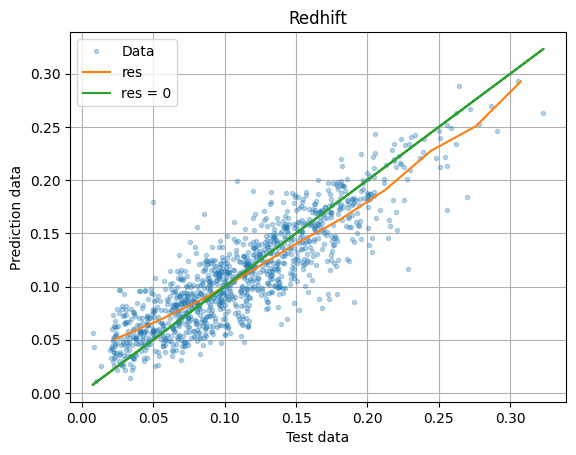

In [70]:
plt.title("Redhift")
count, bins = np.histogram(y_test)
plt.plot(y_test, y_pred , '.', label = 'Data', alpha = 0.3)
plot_data = [np.mean(y_pred[(bins[i] <= y_test) & (y_test < bins[i+1])]) for i in range(len(bins) - 1)]
plt.plot([(bins[i] + bins[i+1])/2 for i in range(len(bins) - 1)], list(plot_data), label = "res")
plt.plot(y_test, y_test, label = "res = 0")
plt.grid(True)
plt.xlabel("Test data")
plt.ylabel("Prediction data")
plt.legend()
plt.savefig("redhift.png")

In [71]:
data = pd.read_csv("sdss_redshift.csv")
x = data[['u', 'g', 'r', 'i', 'z']].to_numpy()

In [72]:
y_pred = np.sum([np.mean([tree.predict(x) for tree in garden], axis=0) for garden in forest], axis=0)

In [74]:
data["redshift"] = y_pred

In [75]:
data.to_csv("sdss_predict.csv")